In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import scienceplots

plt.style.use("science")

SEED = 42

## Preliminary data analysis

In [2]:
from sklearn.preprocessing import OneHotEncoder

data_dir = "ESC-50-master"
df = pd.read_csv(os.path.join(data_dir, "meta", "esc50.csv"))
df = df.query("esc10 == True").reset_index()

categories = df["category"].to_numpy()

encoder = OneHotEncoder()
target = encoder.fit_transform(categories.reshape(-1, 1)).toarray()
df["target"] = target.tolist()
df["class"] = df["target"].apply(lambda x: np.argmax(x))

df[["category", "class"]].drop_duplicates().set_index("class").sort_index()

,category
class,
0,chainsaw
1,clock_tick
2,crackling_fire
3,crying_baby
4,dog
5,helicopter
6,rain
7,rooster
8,sea_waves


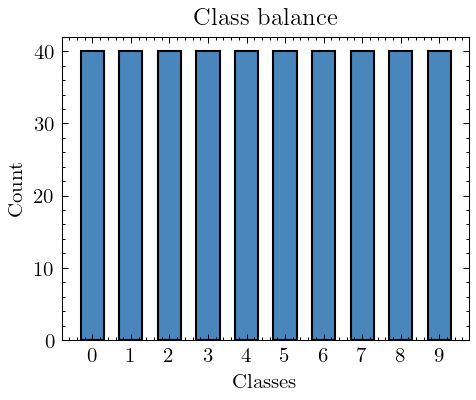

In [3]:
plt.figure(dpi=150)
g = sns.histplot(df, x="class", discrete=True, shrink=0.6)
plt.title("Class balance")
plt.xlabel("Classes")
plt.xticks(np.arange(10))
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "class_balance.png"), dpi=150)
plt.show()

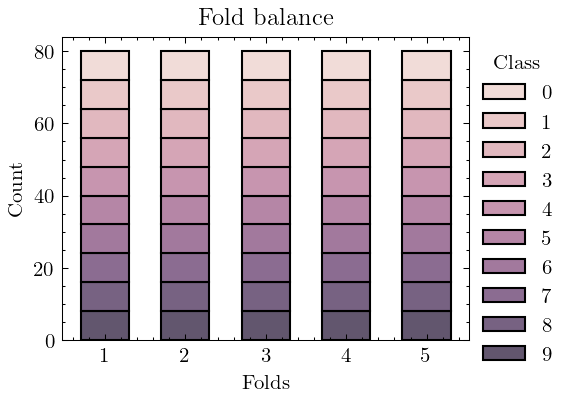

In [4]:
plt.figure(dpi=150)
sns.histplot(df, x="fold", hue="class", discrete=True, shrink=0.6, multiple="stack")
sns.move_legend(plt.gca(), loc="upper right", bbox_to_anchor=(1.25, 1), title="Class")
plt.title("Fold balance")
plt.xlabel("Folds")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "fold_balance.png"), dpi=150)
plt.show()

## Feature extraction

In [5]:
import torch
import torchaudio


class myPipeline(torch.nn.Module):
    def __init__(
        self,
        n_mfcc: int = 40,
        sample_rate=44100,
        mtWin=1,
        mtStep=0.5,
        stWin=0.02,
        stStep=0.01,
    ):
        super().__init__()
        self.n_mfcc = n_mfcc
        self.sample_rate = sample_rate
        self.mtWin = np.floor(mtWin * sample_rate).astype(int)
        self.mtStep = np.floor(mtStep * sample_rate).astype(int)
        self.stWin = np.floor(stWin * sample_rate).astype(int)
        self.stStep = np.floor(stStep * sample_rate).astype(int)

        self.mfcc = torchaudio.transforms.MFCC(
            sample_rate=self.sample_rate,
            n_mfcc=self.n_mfcc,
            melkwargs={"n_fft": 2048, "hop_length": 512},
            log_mels=True,
        )

    def windowize(self, waveform: torch.Tensor, win: int, step: int) -> torch.Tensor:
        mtWindows = waveform.unfold(1, win, step)
        return mtWindows

    def timeFeatExtraction(self, waveform: torch.Tensor) -> tuple[
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
    ]:
        mtWindows = self.windowize(waveform, self.mtWin, self.mtStep)
        mtZCR_mean = torch.zeros(mtWindows.shape[1])
        mtZCR_std = torch.zeros(mtWindows.shape[1])
        energy_mean = torch.zeros(mtWindows.shape[1])
        energy_std = torch.zeros(mtWindows.shape[1])
        energyEntropy_mean = torch.zeros(mtWindows.shape[1])
        energyEntropy_std = torch.zeros(mtWindows.shape[1])
        for i in range(mtWindows.shape[1]):
            mtWindow = mtWindows[:, i, :]
            stWindows = self.windowize(mtWindow, self.stWin, self.stStep)
            zcr = torch.zeros(stWindows.shape[1])
            energy = torch.zeros(stWindows.shape[1])
            energyEntropy = torch.zeros(stWindows.shape[1])
            for j in range(stWindows.shape[1]):
                stWindow = stWindows[:, j, :]
                # Zero Crossing Rate
                zcr[j] = (
                    1
                    / (2 * stWindow.shape[1])
                    * torch.sum(torch.abs(torch.diff(torch.sign(stWindow[0, :]))))
                )

                # Energy
                energy[j] = (1 / (len(stWindow))) * torch.sum(torch.abs(stWindow**2))

                # Energy entropy
                eps = 1e-8
                subFramesLen = 147
                subFrames = stWindow.reshape(1, -1, subFramesLen)
                subFramesEnergy = (
                    1 / subFramesLen * torch.sum(torch.abs(subFrames**2), dim=2)
                )
                subFramesEnergyNorm = subFramesEnergy / (
                    torch.sum(subFramesEnergy) + eps
                )
                energyEntropy[j] = -torch.sum(
                    subFramesEnergyNorm * torch.log2(subFramesEnergyNorm + eps)
                )

            mtZCR_mean[i] = torch.mean(zcr)
            mtZCR_std[i] = torch.std(zcr)
            energy_mean[i] = torch.mean(energy)
            energy_std[i] = torch.std(energy)
            energyEntropy_mean[i] = torch.mean(energyEntropy)
            energyEntropy_std[i] = torch.std(energyEntropy)

        ltZCR_mean = torch.mean(mtZCR_mean).unsqueeze(0)
        ltZCR_std = torch.mean(mtZCR_std).unsqueeze(0)
        ltenergy_mean = torch.mean(energy_mean).unsqueeze(0)
        ltenergy_std = torch.mean(energy_std).unsqueeze(0)
        ltenergyEntropy_mean = torch.mean(energyEntropy_mean).unsqueeze(0)
        ltenergyEntropy_std = torch.mean(energyEntropy_std).unsqueeze(0)

        return (
            ltZCR_mean,
            ltZCR_std,
            ltenergy_mean,
            ltenergy_std,
            ltenergyEntropy_mean,
            ltenergyEntropy_std,
        )

    def forward(self, waveform: torch.Tensor, sample_rate) -> torch.Tensor:
        if sample_rate != self.sample_rate:
            waveform = torchaudio.functional.resample(
                waveform, sample_rate, self.sample_rate
            )
        mfcc = self.mfcc(waveform).mean(dim=2).squeeze(0)
        timeFeatures = self.timeFeatExtraction(waveform)

        features = torch.cat(
            (
                mfcc,
                timeFeatures[0],
                timeFeatures[1],
                timeFeatures[2],
                timeFeatures[3],
                timeFeatures[4],
                timeFeatures[5],
            )
        )
        return features

In [6]:
n_features = 46
feature_extractor = myPipeline()
features = torch.zeros(len(df), n_features)
for i, row in tqdm(df.iterrows()):
    waveform, sample_rate = torchaudio.load(
        os.path.join(data_dir, "audio", row["filename"]),
    )
    features[i] = feature_extractor(waveform, sample_rate)

400it [00:23, 17.31it/s]


## Dimensionality reduction

### PCA

array([0.24077821, 0.09379186])

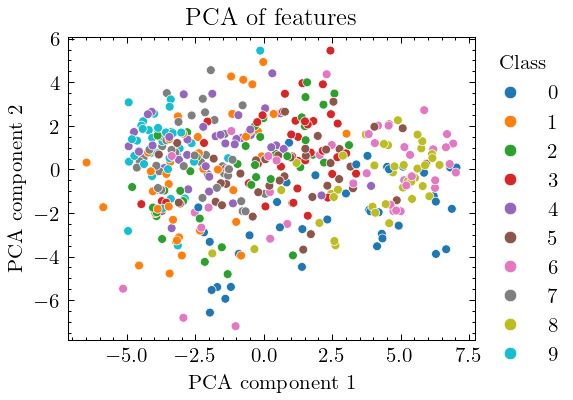

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize Features
scaler = StandardScaler()
features = scaler.fit_transform(features)

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)
display(pca.explained_variance_ratio_)

# Plot PCA
plt.figure(dpi=150)
ax = sns.scatterplot(
    x=features_pca[:, 0],
    y=features_pca[:, 1],
    hue=df["class"],
    palette="tab10",
    size=0.5,
    legend=True,
)
h, l = ax.get_legend_handles_labels()
ax.legend(h[:-1], l[:-1], title="Class", loc="upper right", bbox_to_anchor=(1.25, 1))
plt.title("PCA of features")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "pca.png"), dpi=150)
plt.show()

### t-SNE

/Users/filippouslenghi/audio-pattern/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


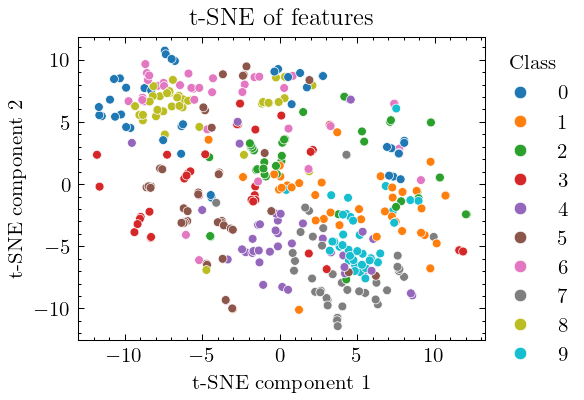

In [8]:
# Apply t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
features_tsne = tsne.fit_transform(features)

# Plot t-SNE
plt.figure(dpi=150)
ax = sns.scatterplot(
    x=features_tsne[:, 0],
    y=features_tsne[:, 1],
    hue=df["class"],
    palette="tab10",
    size=0.5,
    legend=True,
)
h, l = ax.get_legend_handles_labels()
ax.legend(h[:-1], l[:-1], title="Class", loc="upper right", bbox_to_anchor=(1.25, 1))
plt.title("t-SNE of features")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "tsne.png"), dpi=150)
plt.show()

## Clustering with k-mean

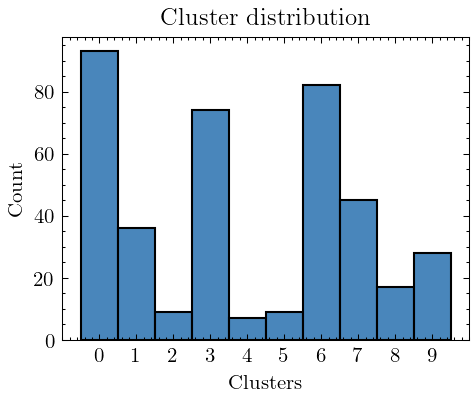

In [9]:
# Apply k-means clustering
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=10,
    init="random",
    n_init=50,
    random_state=SEED,
)
clusters = kmeans.fit_predict(features)

plt.figure(dpi=150)
sns.histplot(
    clusters,
    discrete=True,
)
plt.xticks(np.arange(10))
plt.title("Cluster distribution")
plt.xlabel("Clusters")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "cluster_distribution.png"), dpi=150)
plt.show()

### Plotting

#### PCA

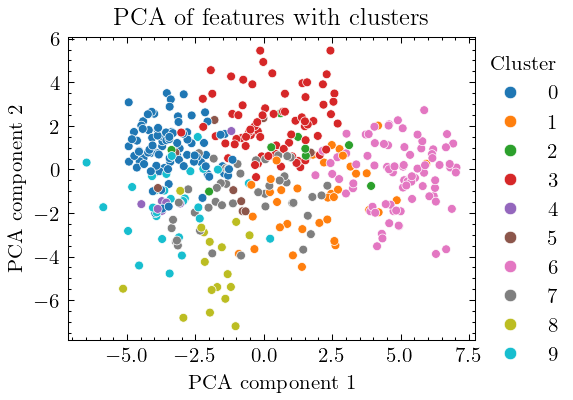

In [10]:
# Plot PCA with clusters
plt.figure(dpi=150)
ax = sns.scatterplot(
    x=features_pca[:, 0],
    y=features_pca[:, 1],
    hue=clusters,
    palette="tab10",
    legend=True,
    size=0.5,
)
h, l = ax.get_legend_handles_labels()
ax.legend(h[:-1], l[:-1], title="Cluster", loc="upper right", bbox_to_anchor=(1.25, 1))
plt.title("PCA of features with clusters")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "pca_clusters.png"), dpi=150)
plt.show()

#### t-SNE

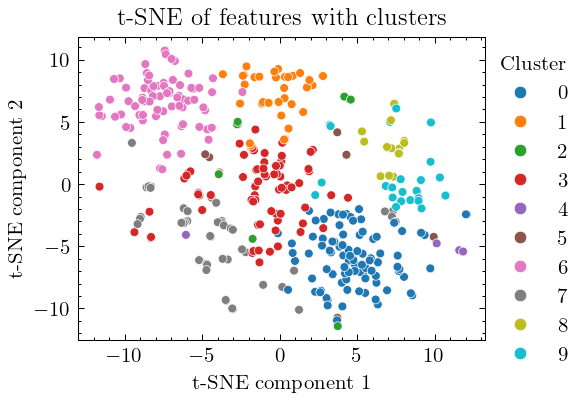

In [11]:
# Plot t-SNE with clusters
plt.figure(dpi=150)
ax = sns.scatterplot(
    x=features_tsne[:, 0],
    y=features_tsne[:, 1],
    hue=clusters,
    palette="tab10",
    legend=True,
    size=0.5,
)
h, l = ax.get_legend_handles_labels()
ax.legend(h[:-1], l[:-1], title="Cluster", loc="upper right", bbox_to_anchor=(1.25, 1))
plt.title("t-SNE of features with clusters")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "tsne_clusters.png"), dpi=150)
plt.show()

### Evaluating clusters

In [12]:
from scipy.spatial import distance_matrix


def similarity_matrix(X):
    dist_matrix = distance_matrix(X, X)
    normalized_dist_matrix = dist_matrix / np.max(dist_matrix)
    similarity_matrix = 1 - normalized_dist_matrix
    return similarity_matrix

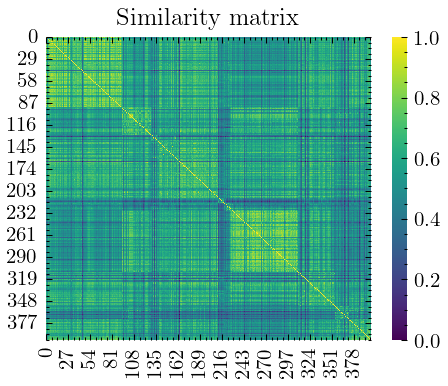

In [13]:
sorted_features = features[np.argsort(clusters)]
sim_matrix = similarity_matrix(sorted_features)
plt.figure(dpi=150)
sns.heatmap(sim_matrix, cmap="viridis")
plt.title("Similarity matrix")
plt.show()

#### Sorting by class

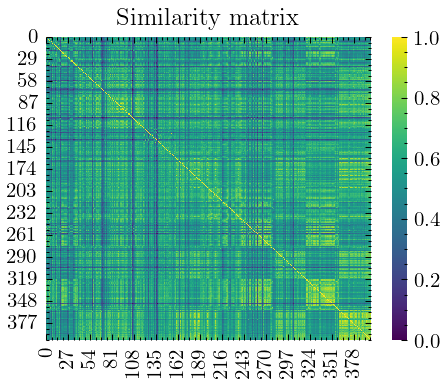

In [14]:
sorted_features = features[np.argsort(df["class"])]
sim_matrix = similarity_matrix(sorted_features)
plt.figure(dpi=150)
sns.heatmap(sim_matrix, cmap="viridis")
plt.title("Similarity matrix")
plt.show()

## Experiments

### Data split

In [15]:
from sklearn.model_selection import train_test_split

X = features
y = df["class"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

### Dummy classifier

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.20      0.25      0.22         8
           2       0.17      0.12      0.14         8
           3       0.11      0.12      0.12         8
           4       0.11      0.12      0.12         8
           5       0.00      0.00      0.00         8
           6       0.12      0.12      0.12         8
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         8

    accuracy                           0.07        80
   macro avg       0.07      0.07      0.07        80
weighted avg       0.07      0.07      0.07        80



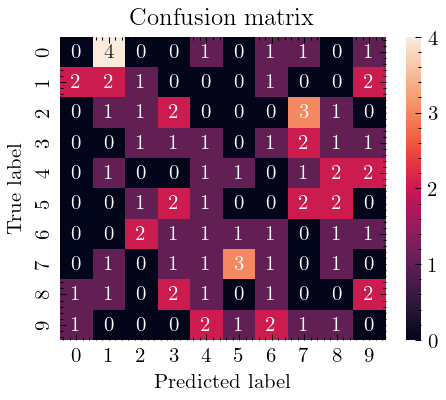

In [16]:
# Create dummy classifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix

dummy = DummyClassifier(strategy="uniform", random_state=SEED)
y_pred = dummy.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))

plt.figure(dpi=150)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.title("Confusion matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

### KNN

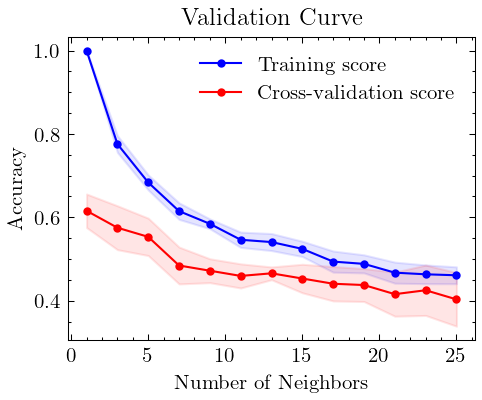

In [17]:
# Train a knn classifier on the features with onevsrest strategy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve

param_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
train_scores, test_scores = validation_curve(
    KNeighborsClassifier(),
    X_train,
    y_train,
    param_name="n_neighbors",
    param_range=param_range,
    cv=5,
    scoring="accuracy",
)

# Calculate mean and standard deviation of training scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation of test scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(dpi=150)
plt.plot(
    param_range,
    train_mean,
    label="Training score",
    color="blue",
    marker="o",
    markersize=3,
)
plt.fill_between(
    param_range,
    train_mean - train_std,
    train_mean + train_std,
    alpha=0.1,
    color="blue",
)
plt.plot(
    param_range,
    test_mean,
    label="Cross-validation score",
    color="red",
    marker="o",
    markersize=3,
)
plt.fill_between(
    param_range,
    test_mean - test_std,
    test_mean + test_std,
    alpha=0.1,
    color="red",
)
plt.title("Validation Curve")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

              precision    recall  f1-score   support

           0       0.67      0.50      0.57         8
           1       0.44      0.50      0.47         8
           2       0.50      0.38      0.43         8
           3       1.00      1.00      1.00         8
           4       0.71      0.62      0.67         8
           5       0.55      0.75      0.63         8
           6       0.60      0.38      0.46         8
           7       1.00      0.75      0.86         8
           8       0.67      1.00      0.80         8
           9       0.70      0.88      0.78         8

    accuracy                           0.68        80
   macro avg       0.68      0.68      0.67        80
weighted avg       0.68      0.68      0.67        80



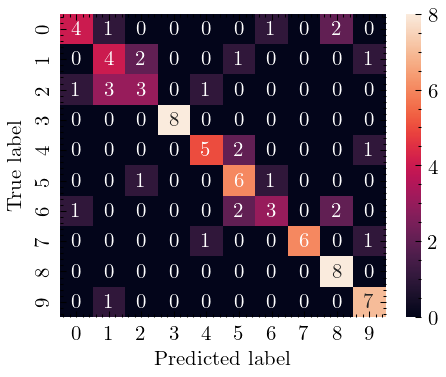

In [18]:
# Train a knn classifier with found hyperparameter
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(dpi=150)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

### SVM

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       0.71      0.62      0.67         8
           2       0.78      0.88      0.82         8
           3       1.00      1.00      1.00         8
           4       1.00      0.88      0.93         8
           5       0.75      0.75      0.75         8
           6       0.38      0.38      0.38         8
           7       1.00      1.00      1.00         8
           8       0.88      0.88      0.88         8
           9       0.88      0.88      0.88         8

    accuracy                           0.80        80
   macro avg       0.80      0.80      0.80        80
weighted avg       0.80      0.80      0.80        80



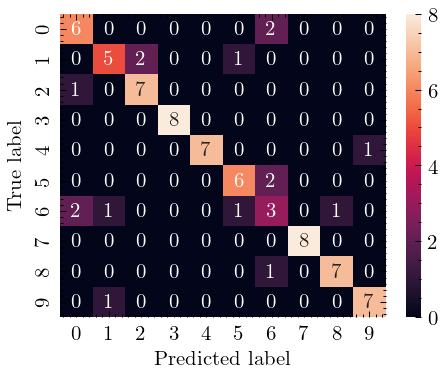

In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "gamma": [0.01, 0.1, 1, 10, 100],
    "kernel": ["rbf", "poly", "sigmoid"],
}

grid_search = GridSearchCV(SVC(), param_grid, refit=True, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

plt.figure(dpi=150)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

### Simple MLP

In [20]:
# Train an MLP Classifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

X = features
y = df["class"]
clf = MLPClassifier(
    hidden_layer_sizes=(70, 50, 50),
    max_iter=10000,
    n_iter_no_change=10,
    solver="sgd",
    activation="relu",
    learning_rate_init=0.01,
    random_state=SEED,
)
scores = cross_val_score(clf, X, y, cv=5)
print(f"Accuracy: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")

Accuracy: 0.63 (+/- 0.13)


#### Grid search

In [ ]:
# Grid search for MLP
from sklearn.model_selection import GridSearchCV

param_grid = {
    "estimator__hidden_layer_sizes": [(80, 50), (80, 50, 50)],
    "estimator__learning_rate_init": [0.01, 0.001],
    "estimator__solver": ["adam", "sgd"],
    "estimator__activation": ["relu", "tanh"],
    "estimator__alpha": [0.0001, 0.001, 0.01],
    "estimator__batch_size": [32, 64],
}

clf = MLPClassifier(
    max_iter=5000,
    n_iter_no_change=10,
    random_state=SEED,
)

grid_search = GridSearchCV(
    clf, param_grid, refit=True, cv=5, scoring="accuracy", n_jobs=-1
)
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
pd.DataFrame(grid_search.cv_results_).to_csv("mlp_grid_search.csv", index=False)

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

plt.figure(dpi=150)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()